In [1]:
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, AUROC
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection

In [2]:
# Load dataset.
dataset = ds.data.load_spam()
d_in = dataset.input_size    # 57
d_out = dataset.output_size  # 2

# Normalize and split dataset.
mean = dataset.tensors[0].mean(dim=0)
dataset.tensors = (dataset.tensors[0] - mean, dataset.tensors[1])
train_dataset, val_dataset, test_dataset = ds.data.data_split(dataset)

In [3]:
# Prepare dataloaders.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1024, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, pin_memory=True)

In [4]:
# Set up networks
hidden = 128
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [5]:
# Pretrain predictor.
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 0.6168

--------Epoch 2--------
Val loss = 0.7228

--------Epoch 3--------
Val loss = 0.5980

--------Epoch 4--------
Val loss = 0.6023

--------Epoch 5--------
Val loss = 0.5935

--------Epoch 6--------
Val loss = 0.5871

--------Epoch 7--------
Val loss = 0.5538

--------Epoch 8--------
Val loss = 0.5380

--------Epoch 9--------
Val loss = 0.5794

--------Epoch 10--------
Val loss = 0.4789

--------Epoch 11--------
Val loss = 0.4518

--------Epoch 12--------
Val loss = 0.4367

--------Epoch 13--------
Val loss = 0.4257

--------Epoch 14--------
Val loss = 0.4359

--------Epoch 15--------
Val loss = 0.4194

--------Epoch 16--------
Val loss = 0.4265

--------Epoch 17--------
Val loss = 0.4252

--------Epoch 18--------
Val loss = 0.4268

Epoch 00018: reducing learning rate of group 0 to 2.0000e-04.
--------Epoch 19--------
Val loss = 0.4217

Stopping early at epoch 19


In [6]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()
gdfs.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=250,
    max_features=35,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

Starting training with temp = 1.0000

--------Epoch 1 (1 total)--------
Val loss = 0.4070, Zero-temp loss = 0.4132

--------Epoch 2 (2 total)--------
Val loss = 0.3272, Zero-temp loss = 0.3326

--------Epoch 3 (3 total)--------
Val loss = 0.3067, Zero-temp loss = 0.3129

--------Epoch 4 (4 total)--------
Val loss = 0.2998, Zero-temp loss = 0.3054

--------Epoch 5 (5 total)--------
Val loss = 0.2930, Zero-temp loss = 0.2997

--------Epoch 6 (6 total)--------
Val loss = 0.2864, Zero-temp loss = 0.2935

--------Epoch 7 (7 total)--------
Val loss = 0.2764, Zero-temp loss = 0.2843

--------Epoch 8 (8 total)--------
Val loss = 0.2755, Zero-temp loss = 0.2835

--------Epoch 9 (9 total)--------
Val loss = 0.2730, Zero-temp loss = 0.2822

--------Epoch 10 (10 total)--------
Val loss = 0.2584, Zero-temp loss = 0.2681

--------Epoch 11 (11 total)--------
Val loss = 0.2662, Zero-temp loss = 0.2767

--------Epoch 12 (12 total)--------
Val loss = 0.2489, Zero-temp loss = 0.2581

--------Epoch 13 (13

# Evaluate performance

- AUROC and top-1 accuracy increase quickly with the number of selections
- Performance can often be improved by increasing the `patience` parameter, or increasing the number of temperature steps (`temp_steps`)

In [7]:
# For saving results.
num_features = list(range(1, 11)) + list(range(15, 30, 5))
auroc_list = []
acc_list = []

# Metrics (softmax is applied automatically in recent versions of torchmetrics).
auroc_metric = lambda pred, y: AUROC(task='multiclass', num_classes=d_out)(pred.softmax(dim=1), y)
acc_metric = Accuracy(task='multiclass', num_classes=d_out)

# Evaluate.
for num in num_features:
    auroc, acc = gdfs.evaluate(test_loader, num, (auroc_metric, acc_metric))
    auroc_list.append(auroc)
    acc_list.append(acc)
    print(f'Num = {num}, AUROC = {100*auroc:.2f}, Acc = {100*acc:.2f}')

Num = 1, AUROC = 82.74, Acc = 78.48
Num = 2, AUROC = 88.83, Acc = 82.28
Num = 3, AUROC = 92.62, Acc = 85.76
Num = 4, AUROC = 95.25, Acc = 90.54
Num = 5, AUROC = 95.76, Acc = 90.87
Num = 6, AUROC = 96.27, Acc = 91.20
Num = 7, AUROC = 96.36, Acc = 90.98
Num = 8, AUROC = 96.61, Acc = 91.85
Num = 9, AUROC = 96.66, Acc = 92.50
Num = 10, AUROC = 96.92, Acc = 92.17
Num = 15, AUROC = 97.99, Acc = 93.37
Num = 20, AUROC = 97.95, Acc = 93.26
Num = 25, AUROC = 97.97, Acc = 93.80


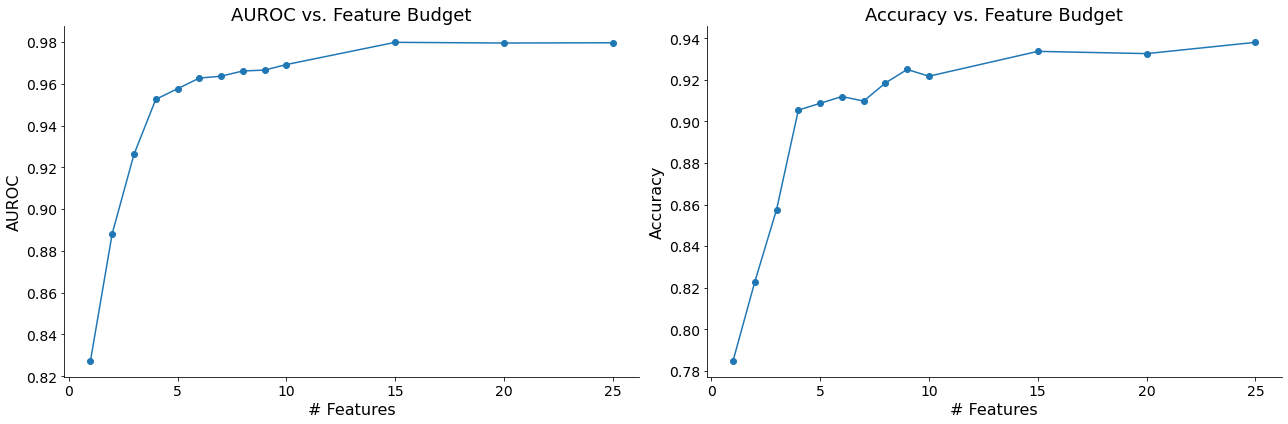

In [8]:
# Plot results
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

# AUROC
plt.sca(axarr[0])
plt.plot(num_features, auroc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('AUROC', fontsize=16)
plt.title('AUROC vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Accuracy
plt.sca(axarr[1])
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot selections

In [9]:
# Generate selections for entire test set.
num_features = range(1, 26)
p_list = []
for num in num_features:
    x, y = ds.data.get_xy(test_dataset)
    pred, x_masked, m = gdfs(x.cuda(), max_features=num)
    p = m.mean(dim=0)
    p_list.append(p.cpu().numpy())

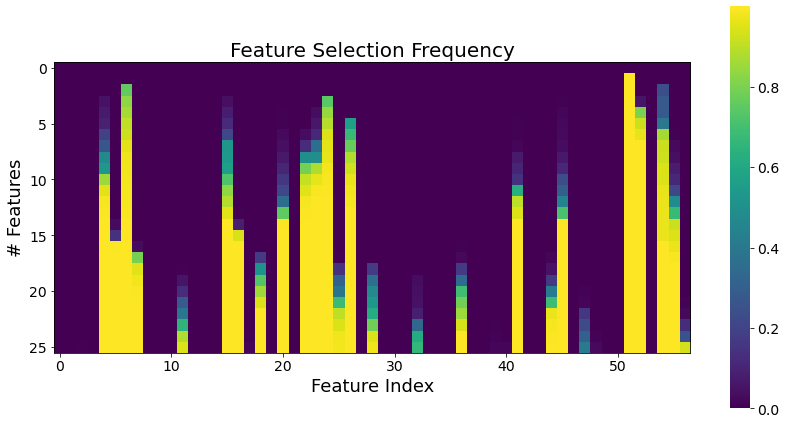

In [10]:
plt.figure(figsize=(12, 6))

# Plot heatmap.
heatmap = np.stack([np.zeros(len(p_list[0]))] + p_list)
plt.imshow(heatmap, cmap='viridis')

# Labels.
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('# Features', fontsize=18)
plt.title('Feature Selection Frequency', fontsize=20)
plt.tick_params(labelsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()